## Create dataloader

In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
import torch
from data_loader import MyDataset
from torch.utils.data import DataLoader
from models.unet import UNet, PretrainedUNet, output_maps
from utils.visualize_star import visualize

In [53]:
labels_path = ".//data//labels.npy"
images_path = ".//data//images.npy"
dataset = MyDataset(images_path, labels_path)
dataset_size = len(dataset)
print(dataset_size)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

4981


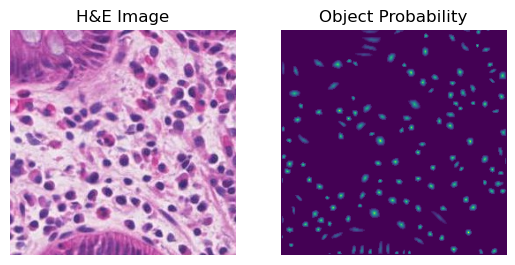

In [60]:
test_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=1)
data = next(iter(test_loader))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('H&E Image')  
plt.imshow(data[0][0].permute(1,2,0))
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Object Probability') 
plt.imshow(data[1][0])
plt.show()


4


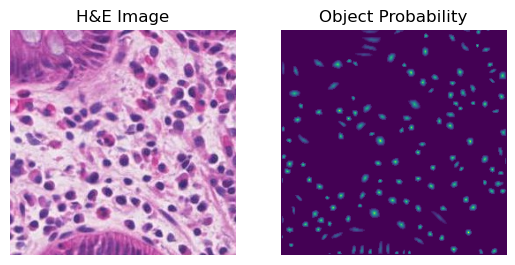

In [61]:
print(len(data))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('H&E Image')  
plt.imshow(data[0][0].permute(1,2,0))
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Object Probability') 
plt.imshow(data[1][0])
plt.show()

In [62]:
image, obj_prob, star_distances, star_angles = data

## visualize "star points" from data loader

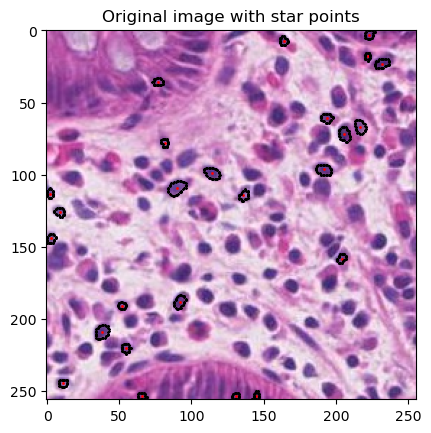

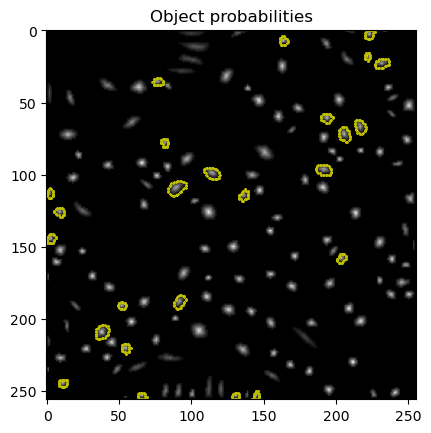

In [64]:
visualize(image[0], obj_prob[0], star_distances[0], star_angles[0])

In [65]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet(3).to(device)
model1 = output_maps().to(device)

In [66]:
#Hyperparameters taken from paper:
batch_size = 2
lr = 0.0003
num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss1 = torch.nn.BCEWithLogitsLoss()
loss2 = torch.nn.MSELoss(reduction='none')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## Training loop

In [67]:
obj_prob_loss_epoch = []
dist_loss_epoch = []
num_batches = len(train_loader)
for epoch in range(num_epochs):
    obj_prob_running_loss = 0.0
    dist_running_loss = 0.0
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        images, object_probabilities, star_poly_dist, star_angles = data
        images, object_probabilities, star_poly_dist, star_angles = images.to(device), object_probabilities.to(device), star_poly_dist.to(device), star_angles.to(device)
        outputs = model(images)
        pred_prob, pred_dist = model1(outputs)
        # pdb.set_trace()
        obj_prob_loss = loss1(pred_prob.squeeze(1), object_probabilities)
        dist_loss = torch.mean(loss2(pred_dist, star_poly_dist) * object_probabilities.unsqueeze(1))
        loss = obj_prob_loss + dist_loss
        loss.backward()
        optimizer.step()
        obj_prob_running_loss += obj_prob_loss.item()
        dist_running_loss += dist_loss.item()
    obj_prob_loss_epoch.append(obj_prob_running_loss/num_batches)
    dist_loss_epoch.append(dist_running_loss/num_batches)
    print("Epoch: {}, Object Probability Loss: {}, Distance Loss: {}, Loss: {}".format(epoch, obj_prob_loss_epoch[-1], dist_loss_epoch[-1], loss.item()))


ValueError: too many values to unpack (expected 3)